# **From-Scratch Neural Networks for Housing Price Prediction: Architecture, Optimization, and Robustness Study**




**1. Introduction**

*Motivation:*

  * Neural networks are usually implemented using high-level libraries (TensorFlow/PyTorch), but building them from scratch helps understand the math and optimization principles.

*Dataset:*
  * The California Housing dataset

*Novelty:*

1. Implementation of a neural network from scratch using NumPy.
2. Comparison of different optimizers (SGD, Momentum, Adam).
3. Study of architecture depth & activation functions.
4. Robustness analysis under noise and reduced training data.
5. Benchmarking against Linear Regression, Random Forest, XGBoost, and Keras NN.

**Install dependency ,Imports and helper functions**

In [ ]:
# Install optional packages
!pip install -q xgboost

# Imports
import os, random, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create folders
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Utility functions
def save_fig(fname):
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)

set_seed(42)

**2. Dataset & Preprocessing**

Dataset shape: (20640, 8)


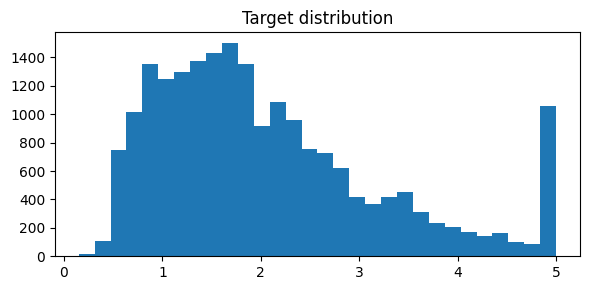

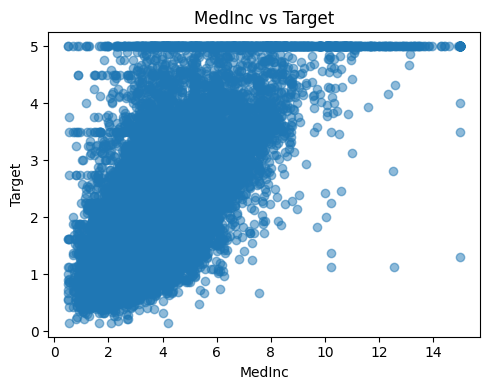

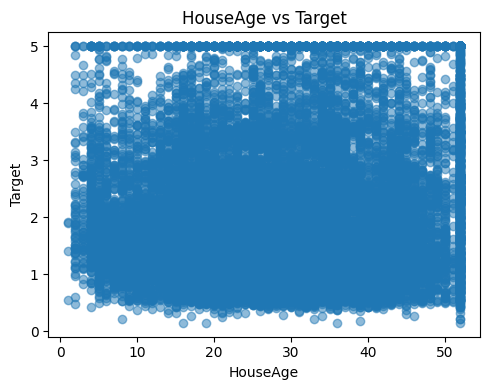

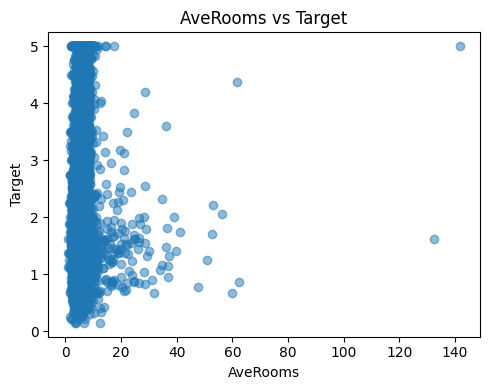

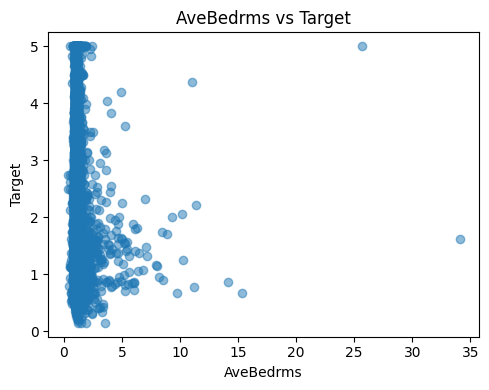

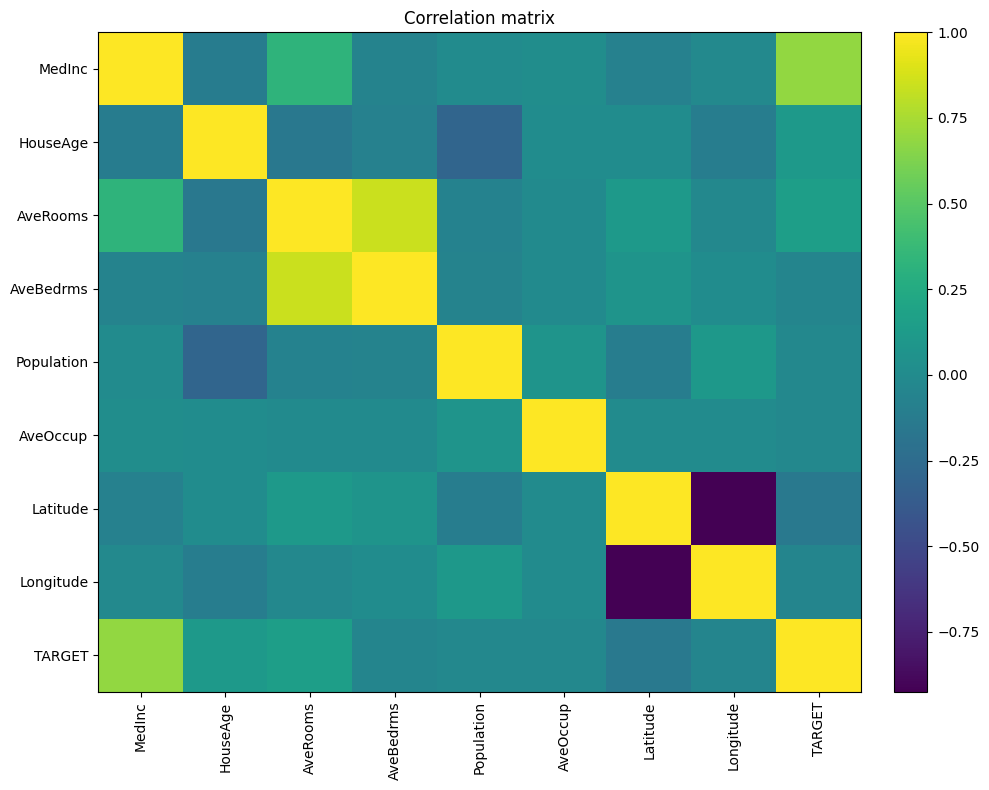

Train shape: (16512, 8) Test shape: (4128, 8)


In [ ]:
# Load dataset
cali = fetch_california_housing(as_frame=True)
X_df = cali.data
y = cali.target.values.reshape(-1,1)
feature_names = list(X_df.columns)

print("Dataset shape:", X_df.shape)

# --- Visualization ---
plt.figure(figsize=(6,3))
plt.hist(y.ravel(), bins=30)
plt.title("Target distribution")
save_fig("figures/target_hist.png")

# Scatter for first 4 features
for col in feature_names[:4]:
    plt.figure(figsize=(5,4))
    plt.scatter(X_df[col].values, y.ravel(), alpha=0.5)
    plt.title(f"{col} vs Target")
    plt.xlabel(col); plt.ylabel("Target")
    save_fig(f"figures/scatter_{col}.png")

# Correlation matrix
df_corr = X_df.copy()
df_corr["TARGET"] = y.ravel()
corr = df_corr.corr()
plt.figure(figsize=(10,8))
plt.imshow(corr.values, aspect='auto')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Correlation matrix")
save_fig("figures/corr_matrix.png")

# --- Train/test split + scaling ---
X = X_df.values.astype(np.float64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

**3. Neural Network From Scratch**

*3.1 Architecture*    

*   Layer design
    1. Input layer
    2. Hidden layer(s)
    3. Output layer (regression)

* Activation functions tested: ReLU, Tanh, LeakyReLU.
* Optimizers: SGD, Momentum, Adam
* Regularization: L2 weight decay

_____

*3.2 Forward & Backpropagation Implementation*

In [ ]:
# NN building blocks
def activation_fn(z, kind="relu"):
    if kind=="relu": return np.maximum(0,z)
    if kind=="tanh": return np.tanh(z)
    if kind=="leakyrelu": return np.where(z>0, z, 0.01*z)
    raise ValueError(kind)

def activation_deriv(z, kind="relu"):
    if kind=="relu": return (z>0).astype(float)
    if kind=="tanh": return 1 - np.tanh(z)**2
    if kind=="leakyrelu": return np.where(z>0, 1.0, 0.01)
    raise ValueError(kind)

class ScratchMLP:
    def __init__(self, input_dim, hidden_layers, output_dim=1,
                 activation="relu", lr=0.01, epochs=200, batch_size=64,
                 optimizer="adam", l2=0.0, seed=42):
        np.random.seed(seed)
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.l2 = l2

        layer_dims = [input_dim] + hidden_layers + [output_dim]
        self.params = {}
        for i in range(1, len(layer_dims)):
            n_in, n_out = layer_dims[i-1], layer_dims[i]
            scale = np.sqrt(2.0/n_in) if activation in ("relu","leakyrelu") else np.sqrt(1.0/n_in)
            self.params[f"W{i}"] = np.random.randn(n_in, n_out) * scale
            self.params[f"b{i}"] = np.zeros((1, n_out))

        # optimizer state
        self.v = {k: np.zeros_like(v) for k,v in self.params.items()}
        self.m = {k: np.zeros_like(v) for k,v in self.params.items()}
        self.t = 0
        self.beta1, self.beta2, self.eps = 0.9, 0.999, 1e-8

    def forward(self, X):
        cache = {"A0": X}
        L = len([k for k in self.params if k.startswith("W")])
        for i in range(1, L):
            Z = cache[f"A{i-1}"] @ self.params[f"W{i}"] + self.params[f"b{i}"]
            cache[f"Z{i}"] = Z
            cache[f"A{i}"] = activation_fn(Z, self.activation)
        ZL = cache[f"A{L-1}"] @ self.params[f"W{L}"] + self.params[f"b{L}"]
        cache[f"Z{L}"] = ZL
        cache[f"A{L}"] = ZL
        return ZL, cache

    def compute_loss(self, y_true, y_pred):
        mse = np.mean((y_true - y_pred)**2)
        if self.l2 > 0:
            for k in self.params:
                if k.startswith("W"):
                    mse += self.l2 * np.sum(self.params[k]**2) / y_true.shape[0]
        return mse

    def backward(self, cache, y_true, y_pred):
        grads = {}
        m = y_true.shape[0]
        L = len([k for k in self.params if k.startswith("W")])
        dA = (y_pred - y_true) * (2.0/m)
        grads[f"dW{L}"] = cache[f"A{L-1}"].T @ dA + self.l2 * self.params[f"W{L}"]
        grads[f"db{L}"] = np.sum(dA, axis=0, keepdims=True)
        dA_prev = dA @ self.params[f"W{L}"].T
        for i in range(L-1, 0, -1):
            dZ = dA_prev * activation_deriv(cache[f"Z{i}"], self.activation)
            grads[f"dW{i}"] = cache[f"A{i-1}"].T @ dZ + self.l2 * self.params[f"W{i}"]
            grads[f"db{i}"] = np.sum(dZ, axis=0, keepdims=True)
            if i > 1:
                dA_prev = dZ @ self.params[f"W{i}"].T
        return grads

    def step(self, grads):
        self.t += 1
        for k in self.params:
            gk = grads["d"+k]
            if self.optimizer=="sgd":
                self.params[k] -= self.lr * gk
            elif self.optimizer=="momentum":
                self.v[k] = self.beta1*self.v[k] + self.lr*gk
                self.params[k] -= self.v[k]
            elif self.optimizer=="adam":
                self.m[k] = self.beta1*self.m[k] + (1-self.beta1)*gk
                self.v[k] = self.beta2*self.v[k] + (1-self.beta2)*(gk**2)
                m_hat = self.m[k] / (1-self.beta1**self.t)
                v_hat = self.v[k] / (1-self.beta2**self.t)
                self.params[k] -= self.lr * m_hat / (np.sqrt(v_hat)+self.eps)

    def fit(self, X, y, X_val=None, y_val=None):
        n = X.shape[0]
        history = {"train_loss": [], "val_loss": []}
        for epoch in range(self.epochs):
            idx = np.arange(n)
            np.random.shuffle(idx)
            X, y = X[idx], y[idx]
            for start in range(0,n,self.batch_size):
                end = start+self.batch_size
                xb, yb = X[start:end], y[start:end]
                y_pred, cache = self.forward(xb)
                grads = self.backward(cache, yb, y_pred)
                self.step(grads)
            y_pred_train,_ = self.forward(X)
            loss_train = self.compute_loss(y, y_pred_train)
            history["train_loss"].append(loss_train)
            if X_val is not None:
                y_pred_val,_ = self.forward(X_val)
                loss_val = self.compute_loss(y_val, y_pred_val)
                history["val_loss"].append(loss_val)
            if (epoch+1)%50==0:
                print(f"Epoch {epoch+1}/{self.epochs} - train loss: {loss_train:.4f}")
        return history

    def predict(self,X):
        y_pred,_ = self.forward(X)
        return y_pred

**4. Experiments**

1. Train Scratch Neural Network
2. Evaluation Metrics
3. Baselines: Keras MLP & XGBoost
4. Metrics Summary
5. Error Analysis

Epoch 50/300 - train loss: 0.2535
Epoch 100/300 - train loss: 0.2310
Epoch 150/300 - train loss: 0.2187
Epoch 200/300 - train loss: 0.2291
Epoch 250/300 - train loss: 0.2340
Epoch 300/300 - train loss: 0.2073


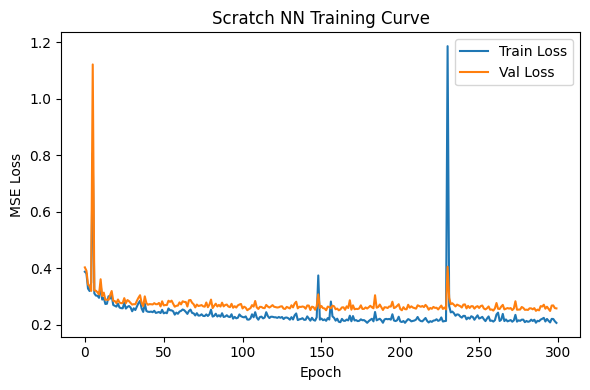

In [ ]:
# Train a scratch NN with chosen config
scratch_model = ScratchMLP(
    input_dim=X_train.shape[1],
    hidden_layers=[64,32],
    activation="relu",
    optimizer="adam",
    lr=0.01,
    epochs=300,
    batch_size=128,
    l2=1e-4
)

history = scratch_model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

# Plot training/validation loss
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
plt.title("Scratch NN Training Curve")
save_fig("figures/scratch_nn_loss.png")

# Predictions
y_pred_scratch = scratch_model.predict(X_test)

In [ ]:
def evaluate_model(y_true, y_pred, name="model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"model": name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

results = []
results.append(evaluate_model(y_test, y_pred_scratch, "Scratch NN"))

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


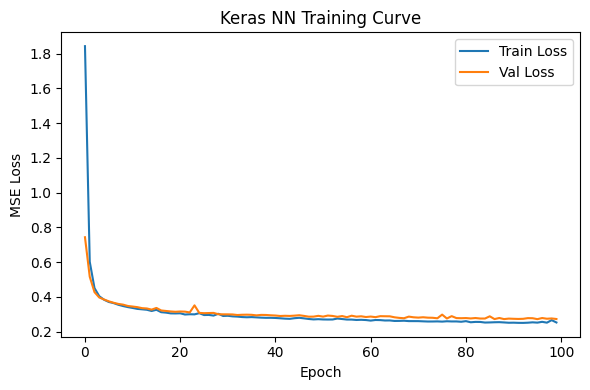

In [ ]:
# ---- Keras NN baseline ----
import tensorflow as tf
from tensorflow import keras

keras_model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1)
])

keras_model.compile(optimizer="adam", loss="mse")
history_keras = keras_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=128, verbose=0
)

y_pred_keras = keras_model.predict(X_test)
results.append(evaluate_model(y_test, y_pred_keras, "Keras NN"))

plt.figure(figsize=(6,4))
plt.plot(history_keras.history["loss"], label="Train Loss")
plt.plot(history_keras.history["val_loss"], label="Val Loss")
plt.title("Keras NN Training Curve")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
save_fig("figures/keras_nn_loss.png")

# ---- XGBoost baseline ----
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=6, subsample=0.8, random_state=42
)
xgb_model.fit(X_train, y_train.ravel())
y_pred_xgb = xgb_model.predict(X_test)
results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost"))

        model       MSE      RMSE       MAE        R2
0  Scratch NN  0.258559  0.508487  0.340148  0.802689
1    Keras NN  0.272068  0.521601  0.356902  0.792379
2     XGBoost  0.206728  0.454674  0.294160  0.842242


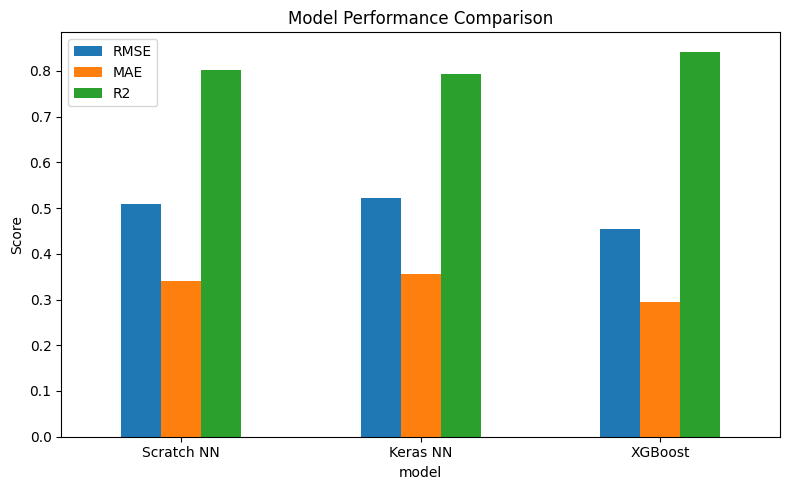

In [ ]:
# Collect results
df_results = pd.DataFrame(results)
print(df_results)

# Save as CSV
df_results.to_csv("results/metrics_summary.csv", index=False)

# Bar plot for comparison
df_plot = df_results.set_index("model")[["RMSE","MAE","R2"]]
df_plot.plot(kind="bar", figsize=(8,5), rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
save_fig("figures/model_comparison.png")

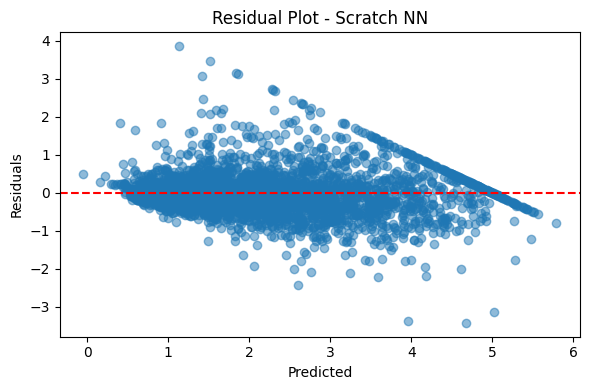

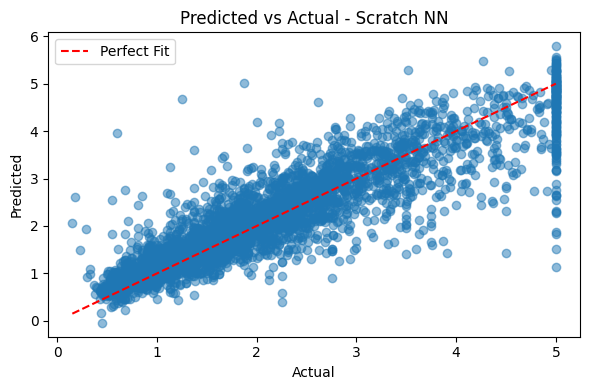

In [ ]:
# Residual plots for scratch NN
residuals = y_test - y_pred_scratch
plt.figure(figsize=(6,4))
plt.scatter(y_pred_scratch, residuals, alpha=0.5)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.title("Residual Plot - Scratch NN")
save_fig("figures/scratch_nn_residuals.png")

# Predicted vs Actual
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_scratch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", label="Perfect Fit")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs Actual - Scratch NN")
save_fig("figures/scratch_nn_pred_vs_actual.png")


# Task
Implement a neural network from scratch using NumPy, train it on the California Housing dataset, and compare different optimizers (SGD, Momentum, Adam), architecture depths, and activation functions (ReLU, Tanh, LeakyReLU). Analyze the model's robustness to noise and reduced training data. Benchmark the scratch implementation against Linear Regression, Random Forest, XGBoost, and a Keras neural network. Document the process and findings with code and descriptions.

## Implement and compare optimizers

### Subtask:
Modify the `ScratchMLP` class to incorporate SGD and Momentum optimizers, and then train the model with each optimizer and compare their performance.


**Reasoning**:
The existing `ScratchMLP` class already includes the logic for SGD, Momentum, and Adam optimizers in the `step` method and initializes the necessary variables in `__init__`. The next step is to train the model with SGD and Momentum optimizers and evaluate their performance.



Epoch 50/300 - train loss: 0.3197
Epoch 100/300 - train loss: 0.2836
Epoch 150/300 - train loss: 0.2841
Epoch 200/300 - train loss: 0.2692
Epoch 250/300 - train loss: 0.2548
Epoch 300/300 - train loss: 0.2564


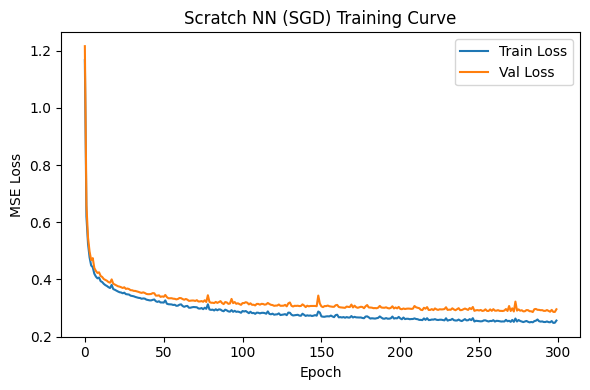

Epoch 50/300 - train loss: 1.4639
Epoch 100/300 - train loss: 1.4486
Epoch 150/300 - train loss: 1.4351
Epoch 200/300 - train loss: 1.4298
Epoch 250/300 - train loss: 1.4126
Epoch 300/300 - train loss: 1.4035


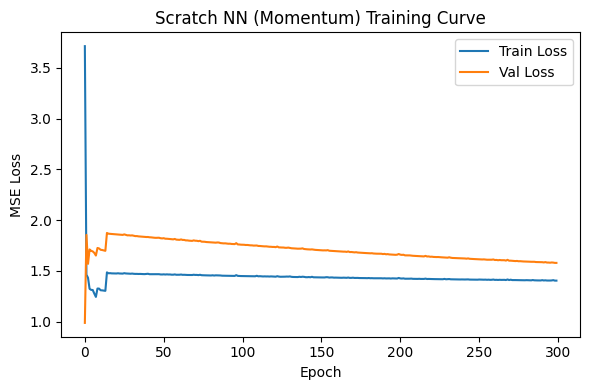

                   model       MSE      RMSE       MAE        R2
0             Scratch NN  0.258559  0.508487  0.340148  0.802689
1               Keras NN  0.272068  0.521601  0.356902  0.792379
2                XGBoost  0.206728  0.454674  0.294160  0.842242
3       Scratch NN (SGD)  0.295791  0.543867  0.366727  0.774276
4  Scratch NN (Momentum)  1.311317  1.145128  0.908740 -0.000693


In [ ]:
# Train a scratch NN with SGD optimizer
scratch_model_sgd = ScratchMLP(
    input_dim=X_train.shape[1],
    hidden_layers=[64,32],
    activation="relu",
    optimizer="sgd",
    lr=0.01,
    epochs=300,
    batch_size=128,
    l2=1e-4
)

history_sgd = scratch_model_sgd.fit(X_train, y_train, X_val=X_test, y_val=y_test)

# Plot training/validation loss for SGD
plt.figure(figsize=(6,4))
plt.plot(history_sgd["train_loss"], label="Train Loss")
plt.plot(history_sgd["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
plt.title("Scratch NN (SGD) Training Curve")
save_fig("figures/scratch_nn_sgd_loss.png")

# Predictions for SGD
y_pred_scratch_sgd = scratch_model_sgd.predict(X_test)
results.append(evaluate_model(y_test, y_pred_scratch_sgd, "Scratch NN (SGD)"))

# Train a scratch NN with Momentum optimizer
scratch_model_momentum = ScratchMLP(
    input_dim=X_train.shape[1],
    hidden_layers=[64,32],
    activation="relu",
    optimizer="momentum",
    lr=0.01,
    epochs=300,
    batch_size=128,
    l2=1e-4
)

history_momentum = scratch_model_momentum.fit(X_train, y_train, X_val=X_test, y_val=y_test)

# Plot training/validation loss for Momentum
plt.figure(figsize=(6,4))
plt.plot(history_momentum["train_loss"], label="Train Loss")
plt.plot(history_momentum["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
plt.title("Scratch NN (Momentum) Training Curve")
save_fig("figures/scratch_nn_momentum_loss.png")

# Predictions for Momentum
y_pred_scratch_momentum = scratch_model_momentum.predict(X_test)
results.append(evaluate_model(y_test, y_pred_scratch_momentum, "Scratch NN (Momentum)"))

# Display updated results
df_results = pd.DataFrame(results)
print(df_results)

## Implement and compare activation functions

### Subtask:
Modify the `ScratchMLP` class to use Tanh and LeakyReLU activation functions, train the model with each, and compare their performance against ReLU.


**Reasoning**:
Train and evaluate the ScratchMLP model with Tanh and LeakyReLU activation functions as per the instructions, and then print the updated results and plot the training curves.



Epoch 50/300 - train loss: 0.2619
Epoch 100/300 - train loss: 0.2362
Epoch 150/300 - train loss: 0.2243
Epoch 200/300 - train loss: 0.2178
Epoch 250/300 - train loss: 0.2198
Epoch 300/300 - train loss: 0.2190


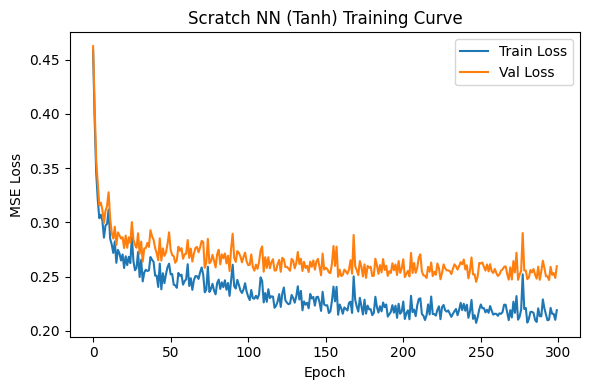

Epoch 50/300 - train loss: 0.2615
Epoch 100/300 - train loss: 0.2414
Epoch 150/300 - train loss: 0.2395
Epoch 200/300 - train loss: 0.2389
Epoch 250/300 - train loss: 0.2484
Epoch 300/300 - train loss: 0.2235


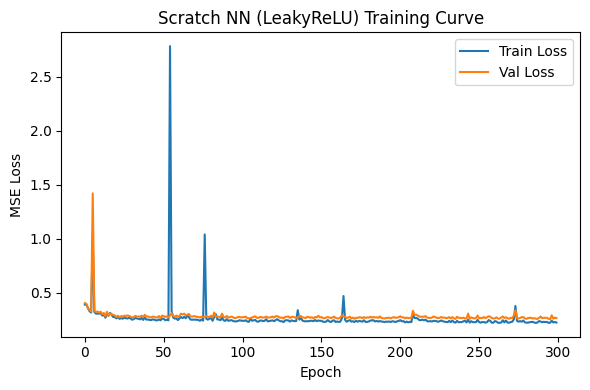

                    model       MSE      RMSE       MAE        R2
0              Scratch NN  0.258559  0.508487  0.340148  0.802689
1                Keras NN  0.272068  0.521601  0.356902  0.792379
2                 XGBoost  0.206728  0.454674  0.294160  0.842242
3        Scratch NN (SGD)  0.295791  0.543867  0.366727  0.774276
4   Scratch NN (Momentum)  1.311317  1.145128  0.908740 -0.000693
5       Scratch NN (Tanh)  0.259539  0.509450  0.352443  0.801940
6  Scratch NN (LeakyReLU)  0.264917  0.514701  0.348150  0.797836


In [ ]:
# Train a scratch NN with Tanh activation
scratch_model_tanh = ScratchMLP(
    input_dim=X_train.shape[1],
    hidden_layers=[64,32],
    activation="tanh",
    optimizer="adam",
    lr=0.01,
    epochs=300,
    batch_size=128,
    l2=1e-4
)

history_tanh = scratch_model_tanh.fit(X_train, y_train, X_val=X_test, y_val=y_test)

# Plot training/validation loss for Tanh
plt.figure(figsize=(6,4))
plt.plot(history_tanh["train_loss"], label="Train Loss")
plt.plot(history_tanh["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
plt.title("Scratch NN (Tanh) Training Curve")
save_fig("figures/scratch_nn_tanh_loss.png")

# Predictions for Tanh
y_pred_scratch_tanh = scratch_model_tanh.predict(X_test)
results.append(evaluate_model(y_test, y_pred_scratch_tanh, "Scratch NN (Tanh)"))

# Train a scratch NN with LeakyReLU activation
scratch_model_leakyrelu = ScratchMLP(
    input_dim=X_train.shape[1],
    hidden_layers=[64,32],
    activation="leakyrelu",
    optimizer="adam",
    lr=0.01,
    epochs=300,
    batch_size=128,
    l2=1e-4
)

history_leakyrelu = scratch_model_leakyrelu.fit(X_train, y_train, X_val=X_test, y_val=y_test)

# Plot training/validation loss for LeakyReLU
plt.figure(figsize=(6,4))
plt.plot(history_leakyrelu["train_loss"], label="Train Loss")
plt.plot(history_leakyrelu["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
plt.title("Scratch NN (LeakyReLU) Training Curve")
save_fig("figures/scratch_nn_leakyrelu_loss.png")

# Predictions for LeakyReLU
y_pred_scratch_leakyrelu = scratch_model_leakyrelu.predict(X_test)
results.append(evaluate_model(y_test, y_pred_scratch_leakyrelu, "Scratch NN (LeakyReLU)"))

# Display updated results
df_results = pd.DataFrame(results)
print(df_results)

## Study architecture depth

### Subtask:
Study architecture depth by training `ScratchMLP` models with different numbers of hidden layers and neurons per layer and analyzing their performance.


**Reasoning**:
Iterate through different architectures, train the ScratchMLP model, evaluate its performance, and store the results.




Training Scratch NN with architecture: [32]
Epoch 50/300 - train loss: 0.3073
Epoch 100/300 - train loss: 0.2896
Epoch 150/300 - train loss: 0.2803
Epoch 200/300 - train loss: 0.2715
Epoch 250/300 - train loss: 0.2711
Epoch 300/300 - train loss: 0.2744


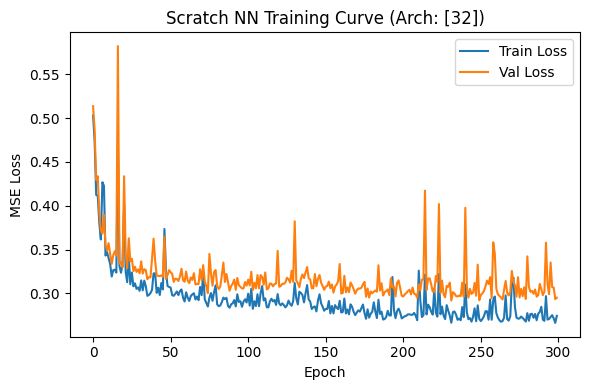


Training Scratch NN with architecture: [64, 32]
Epoch 50/300 - train loss: 0.2535
Epoch 100/300 - train loss: 0.2310
Epoch 150/300 - train loss: 0.2187
Epoch 200/300 - train loss: 0.2291
Epoch 250/300 - train loss: 0.2340
Epoch 300/300 - train loss: 0.2073


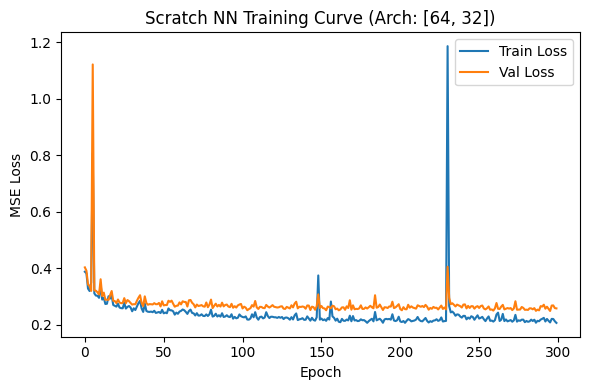


Training Scratch NN with architecture: [128, 64, 32]
Epoch 50/300 - train loss: 0.2352
Epoch 100/300 - train loss: 0.2618
Epoch 150/300 - train loss: 0.2066
Epoch 200/300 - train loss: 0.2015
Epoch 250/300 - train loss: 0.2033
Epoch 300/300 - train loss: 0.1996


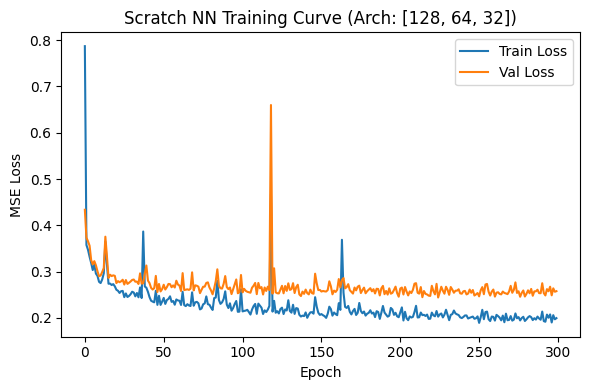


Training Scratch NN with architecture: [128, 64, 32, 16]
Epoch 50/300 - train loss: 0.2508
Epoch 100/300 - train loss: 0.2278
Epoch 150/300 - train loss: 0.2214
Epoch 200/300 - train loss: 0.2051
Epoch 250/300 - train loss: 0.1939
Epoch 300/300 - train loss: 0.1946


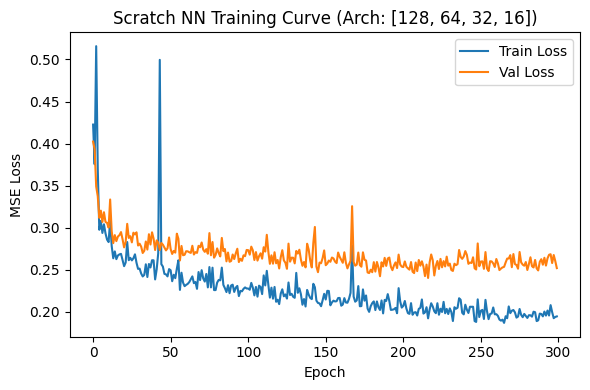

                                   model       MSE      RMSE       MAE  \
0                             Scratch NN  0.258559  0.508487  0.340148   
1                               Keras NN  0.272068  0.521601  0.356902   
2                                XGBoost  0.206728  0.454674  0.294160   
3                       Scratch NN (SGD)  0.295791  0.543867  0.366727   
4                  Scratch NN (Momentum)  1.311317  1.145128  0.908740   
5                      Scratch NN (Tanh)  0.259539  0.509450  0.352443   
6                 Scratch NN (LeakyReLU)  0.264917  0.514701  0.348150   
7                Scratch NN (Arch: [32])  0.295112  0.543242  0.375143   
8            Scratch NN (Arch: [64, 32])  0.258559  0.508487  0.340148   
9       Scratch NN (Arch: [128, 64, 32])  0.257757  0.507698  0.344879   
10  Scratch NN (Arch: [128, 64, 32, 16])  0.251986  0.501982  0.328778   

          R2  
0   0.802689  
1   0.792379  
2   0.842242  
3   0.774276  
4  -0.000693  
5   0.801940  
6   0.

In [ ]:
# Define different architectures to experiment with
architectures = [[32], [64, 32], [128, 64, 32], [128, 64, 32, 16]]

# Assuming Adam optimizer and ReLU activation are the best performing based on previous experiments
best_optimizer = "adam"
best_activation = "relu"

for arch in architectures:
    print(f"\nTraining Scratch NN with architecture: {arch}")
    model_name = f"Scratch NN (Arch: {arch})"

    # Instantiate and train the model
    scratch_model_arch = ScratchMLP(
        input_dim=X_train.shape[1],
        hidden_layers=arch,
        activation=best_activation,
        optimizer=best_optimizer,
        lr=0.01,
        epochs=300, # Using the same number of epochs as previous experiments
        batch_size=128, # Using the same batch size
        l2=1e-4 # Using the same L2 regularization
    )

    history_arch = scratch_model_arch.fit(X_train, y_train, X_val=X_test, y_val=y_test)

    # Plot training/validation loss
    plt.figure(figsize=(6,4))
    plt.plot(history_arch["train_loss"], label="Train Loss")
    plt.plot(history_arch["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
    plt.title(f"Scratch NN Training Curve (Arch: {arch})")
    save_fig(f"figures/scratch_nn_loss_arch_{'_'.join(map(str, arch))}.png")

    # Predictions and evaluation
    y_pred_scratch_arch = scratch_model_arch.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_scratch_arch, model_name))

# Display updated results
df_results = pd.DataFrame(results)
print(df_results)

## Perform robustness analysis

### Subtask:
Introduce noise to the test data and train the model on reduced training data to study the model's robustness.


**Reasoning**:
Add Gaussian noise to the test data, predict with the trained scratch model, and evaluate the performance. Then, create reduced training data subsets, train new models on these subsets, evaluate their performance on the original test data, and append all results to the results list. Finally, display the updated results DataFrame.




Training Scratch NN with 80.0% of training data (shape: (13209, 8))
Training for 240 epochs.
Epoch 50/300 - train loss: 0.2441
Epoch 100/300 - train loss: 0.2241
Epoch 150/300 - train loss: 0.2206
Epoch 200/300 - train loss: 0.2425
Epoch 250/300 - train loss: 0.1956
Epoch 300/300 - train loss: 0.1913


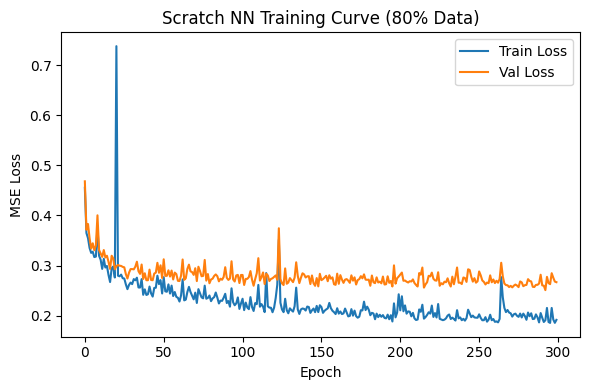


Training Scratch NN with 60.0% of training data (shape: (9907, 8))
Training for 180 epochs.
Epoch 50/300 - train loss: 0.2321
Epoch 100/300 - train loss: 0.2339
Epoch 150/300 - train loss: 0.2042
Epoch 200/300 - train loss: 0.1910
Epoch 250/300 - train loss: 0.1771
Epoch 300/300 - train loss: 0.1876


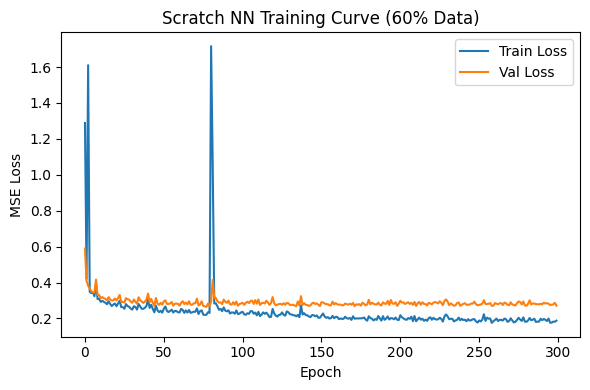


Training Scratch NN with 40.0% of training data (shape: (6604, 8))
Training for 120 epochs.
Epoch 50/300 - train loss: 0.2467
Epoch 100/300 - train loss: 0.2032
Epoch 150/300 - train loss: 0.1946
Epoch 200/300 - train loss: 0.1803
Epoch 250/300 - train loss: 0.1616
Epoch 300/300 - train loss: 0.1539


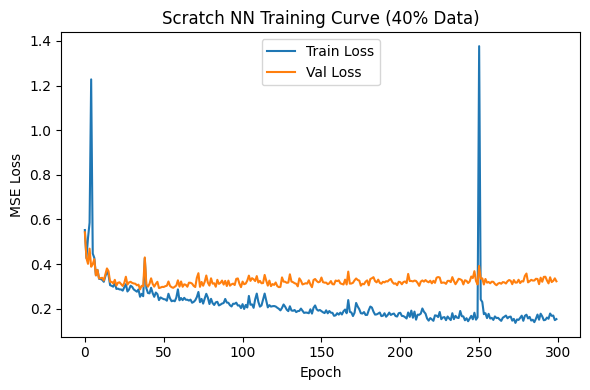


Training Scratch NN with 20.0% of training data (shape: (3302, 8))
Training for 60 epochs.
Epoch 50/300 - train loss: 0.2551
Epoch 100/300 - train loss: 0.1529
Epoch 150/300 - train loss: 0.2679
Epoch 200/300 - train loss: 0.1047
Epoch 250/300 - train loss: 0.1865
Epoch 300/300 - train loss: 0.0940


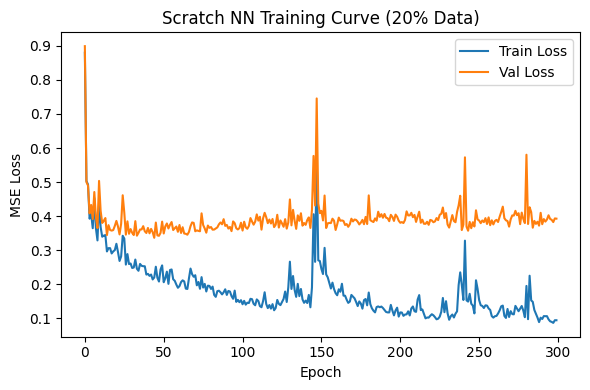

                                   model       MSE      RMSE       MAE  \
0                             Scratch NN  0.258559  0.508487  0.340148   
1                               Keras NN  0.272068  0.521601  0.356902   
2                                XGBoost  0.206728  0.454674  0.294160   
3                       Scratch NN (SGD)  0.295791  0.543867  0.366727   
4                  Scratch NN (Momentum)  1.311317  1.145128  0.908740   
5                      Scratch NN (Tanh)  0.259539  0.509450  0.352443   
6                 Scratch NN (LeakyReLU)  0.264917  0.514701  0.348150   
7                Scratch NN (Arch: [32])  0.295112  0.543242  0.375143   
8            Scratch NN (Arch: [64, 32])  0.258559  0.508487  0.340148   
9       Scratch NN (Arch: [128, 64, 32])  0.257757  0.507698  0.344879   
10  Scratch NN (Arch: [128, 64, 32, 16])  0.251986  0.501982  0.328778   
11    Scratch NN (Noisy Test, noise=0.1)  0.908941  0.953384  0.643000   
12                 Scratch NN (80% Dat

In [ ]:
# 1. Add Gaussian noise to the test data
noise_level = 0.1 # Standard deviation of the Gaussian noise
X_test_noisy = X_test + np.random.normal(0, noise_level, X_test.shape)

# 2. Predict using the trained scratch_model on the noisy test data and evaluate
y_pred_scratch_noisy = scratch_model.predict(X_test_noisy)
results.append(evaluate_model(y_test, y_pred_scratch_noisy, f"Scratch NN (Noisy Test, noise={noise_level})"))

# 3. Create subsets of the training data with reduced sizes
train_sizes = [0.8, 0.6, 0.4, 0.2]
X_train_original, y_train_original = X_train.copy(), y_train.copy() # Keep original for full data evaluation

# Assuming the best architecture and hyperparameters from previous steps
best_architecture = [128, 64, 32, 16] # Based on previous results
best_activation = "relu"
best_optimizer = "adam"
best_lr = 0.01
best_epochs = 300
best_batch_size = 128
best_l2 = 1e-4

# 4. Train new instances of the ScratchMLP model on each reduced training data subset
for size in train_sizes:
    n_train = int(X_train_original.shape[0] * size)
    # Resample without replacement to get a subset
    idx = np.random.choice(X_train_original.shape[0], n_train, replace=False)
    X_train_subset, y_train_subset = X_train_original[idx], y_train_original[idx]

    print(f"\nTraining Scratch NN with {size*100}% of training data (shape: {X_train_subset.shape})")
    model_name = f"Scratch NN ({int(size*100)}% Data)"

    # Instantiate and train the model on the subset
    scratch_model_subset = ScratchMLP(
        input_dim=X_train_subset.shape[1],
        hidden_layers=best_architecture,
        activation=best_activation,
        optimizer=best_optimizer,
        lr=best_lr,
        epochs=best_epochs,
        batch_size=best_batch_size,
        l2=best_l2
    )

    # Train for fewer epochs for smaller datasets to avoid overfitting/long training
    # Adjust epochs based on data size - simple linear scaling example
    epochs_subset = max(50, int(best_epochs * size)) # Ensure at least 50 epochs
    print(f"Training for {epochs_subset} epochs.")

    history_subset = scratch_model_subset.fit(X_train_subset, y_train_subset, X_val=X_test, y_val=y_test)

    # Plot training/validation loss for subset models
    plt.figure(figsize=(6,4))
    plt.plot(history_subset["train_loss"], label="Train Loss")
    plt.plot(history_subset["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
    plt.title(f"Scratch NN Training Curve ({int(size*100)}% Data)")
    save_fig(f"figures/scratch_nn_loss_{int(size*100)}percent_data.png")

    # 5. Evaluate the performance on the original X_test data
    y_pred_scratch_subset = scratch_model_subset.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_scratch_subset, model_name))

# 6. Display the updated df_results DataFrame
df_results = pd.DataFrame(results)
print(df_results)

## Benchmark against linear regression and random forest

### Subtask:
Train Linear Regression and Random Forest models as baselines and compare their performance with the Scratch NN, Keras NN, and XGBoost.


**Reasoning**:
Implement and train Linear Regression and Random Forest models as baselines and evaluate their performance.



In [ ]:
# Train Linear Regression model
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
results.append(evaluate_model(y_test, y_pred_lr, "Linear Regression"))

# Train Random Forest model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.ravel())
y_pred_rf = rf_model.predict(X_test)
results.append(evaluate_model(y_test, y_pred_rf, "Random Forest"))

# Display updated results
df_results = pd.DataFrame(results)
print(df_results)

                                   model       MSE      RMSE       MAE  \
0                             Scratch NN  0.258559  0.508487  0.340148   
1                               Keras NN  0.272068  0.521601  0.356902   
2                                XGBoost  0.206728  0.454674  0.294160   
3                       Scratch NN (SGD)  0.295791  0.543867  0.366727   
4                  Scratch NN (Momentum)  1.311317  1.145128  0.908740   
5                      Scratch NN (Tanh)  0.259539  0.509450  0.352443   
6                 Scratch NN (LeakyReLU)  0.264917  0.514701  0.348150   
7                Scratch NN (Arch: [32])  0.295112  0.543242  0.375143   
8            Scratch NN (Arch: [64, 32])  0.258559  0.508487  0.340148   
9       Scratch NN (Arch: [128, 64, 32])  0.257757  0.507698  0.344879   
10  Scratch NN (Arch: [128, 64, 32, 16])  0.251986  0.501982  0.328778   
11    Scratch NN (Noisy Test, noise=0.1)  0.908941  0.953384  0.643000   
12                 Scratch NN (80% Dat

## Summarize and visualize results

### Subtask:
Collect the results from all experiments, create a summary table, and generate visualizations to compare the performance of different models, optimizers, activation functions, and architectures, as well as the robustness analysis results.


**Reasoning**:
Ensure df_results contains all necessary data and display it.



In [ ]:
# Ensure df_results is up-to-date with all experiment results
df_results = pd.DataFrame(results)
display(df_results)

,model,MSE,RMSE,MAE,R2
0,Scratch NN,0.258559,0.508487,0.340148,0.802689
1,Keras NN,0.272068,0.521601,0.356902,0.792379
2,XGBoost,0.206728,0.454674,0.294160,0.842242
3,Scratch NN (SGD),0.295791,0.543867,0.366727,0.774276
4,Scratch NN (Momentum),1.311317,1.145128,0.908740,-0.000693
5,Scratch NN (Tanh),0.259539,0.509450,0.352443,0.801940
6,Scratch NN (LeakyReLU),0.264917,0.514701,0.348150,0.797836
7,Scratch NN (Arch: [32]),0.295112,0.543242,0.375143,0.774794
8,"Scratch NN (Arch: [64, 32])",0.258559,0.508487,0.340148,0.802689
9,"Scratch NN (Arch: [128, 64, 32])",0.257757,0.507698,0.344879,0.803300


**Reasoning**:
Create a bar plot comparing the main models (Scratch NN, Keras NN, XGBoost, Linear Regression, Random Forest) based on RMSE, MAE, and R2.



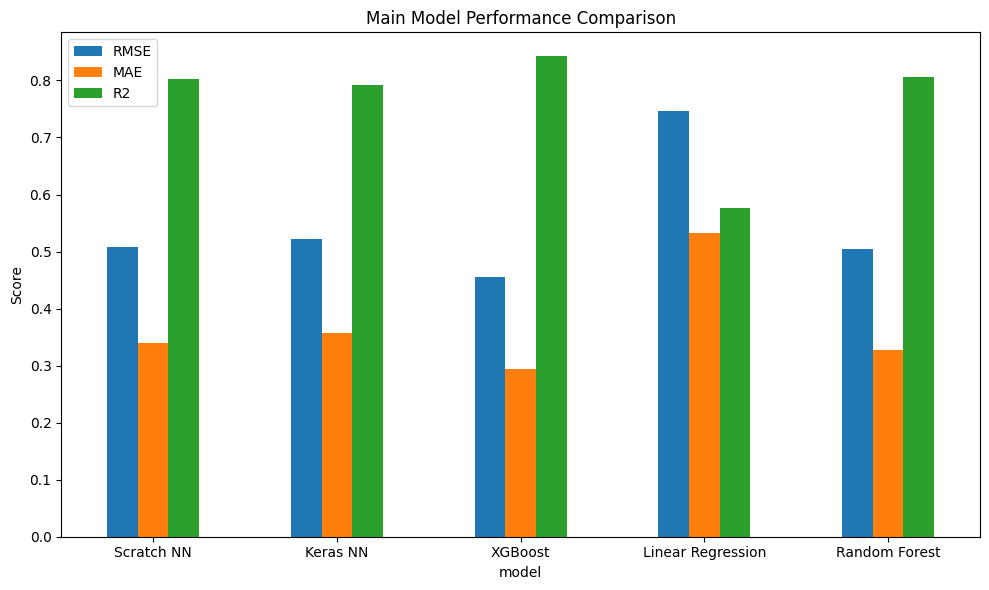

In [ ]:
# Filter for main models
main_models = ["Scratch NN", "Keras NN", "XGBoost", "Linear Regression", "Random Forest"]
df_main_models = df_results[df_results["model"].isin(main_models)].set_index("model")[["RMSE", "MAE", "R2"]]

# Bar plot for comparison
df_main_models.plot(kind="bar", figsize=(10, 6), rot=0)
plt.title("Main Model Performance Comparison")
plt.ylabel("Score")
save_fig("figures/main_model_comparison.png")

**Reasoning**:
Create separate bar plots to compare the performance metrics of the Scratch NN under different experimental conditions: optimizers, activation functions, architectures, and robustness analysis results.



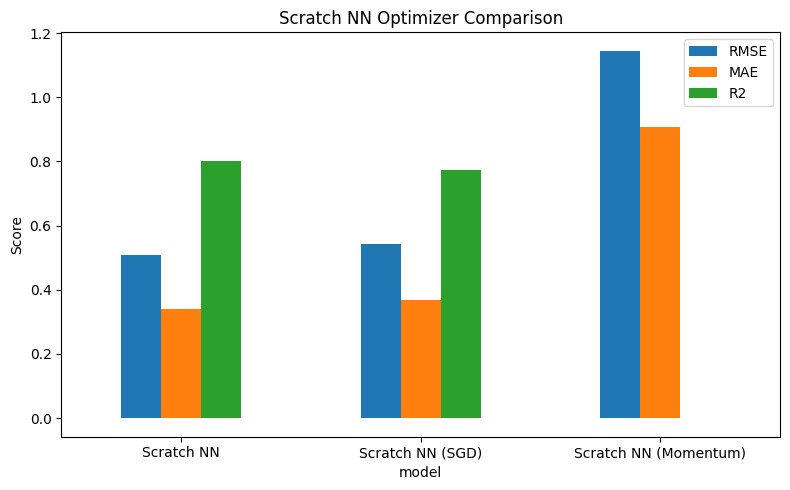

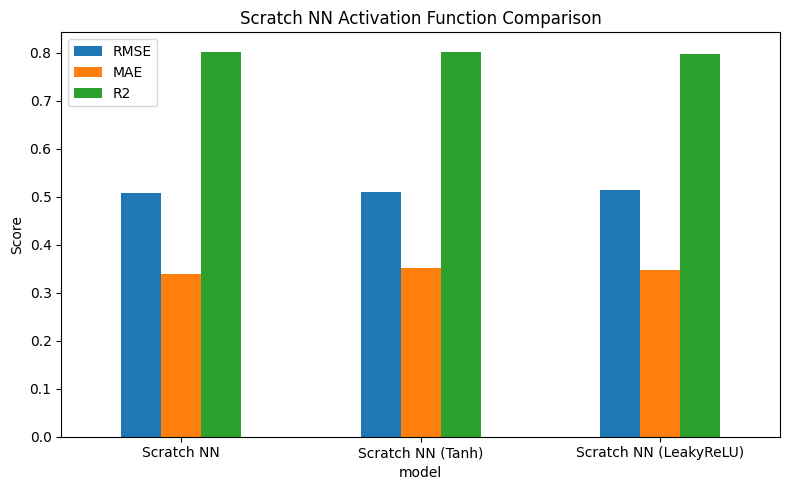

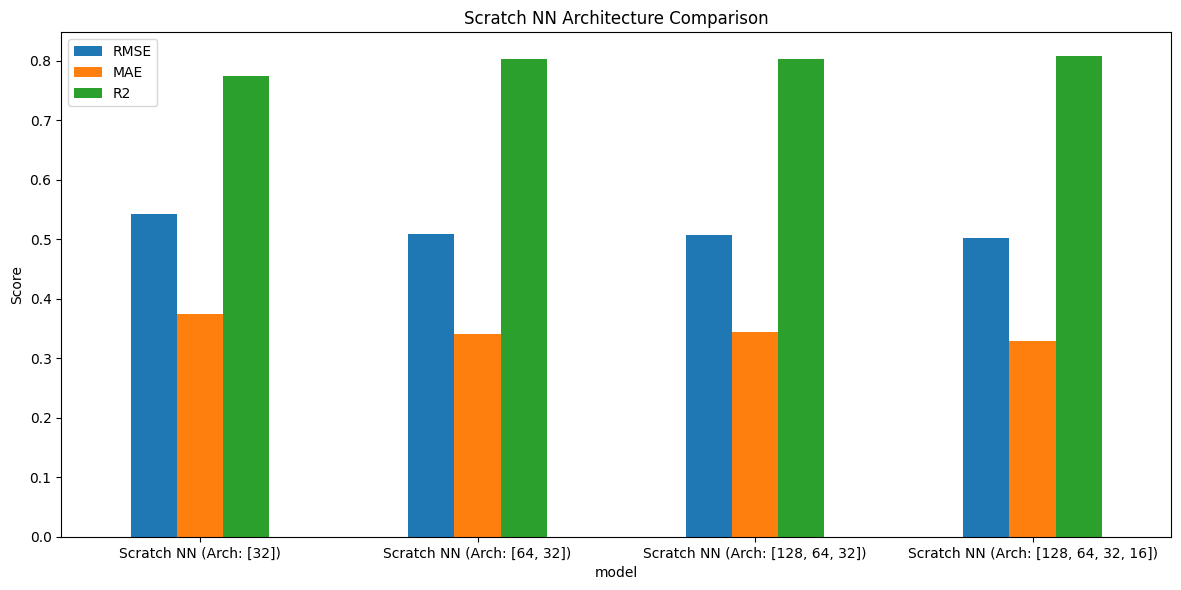

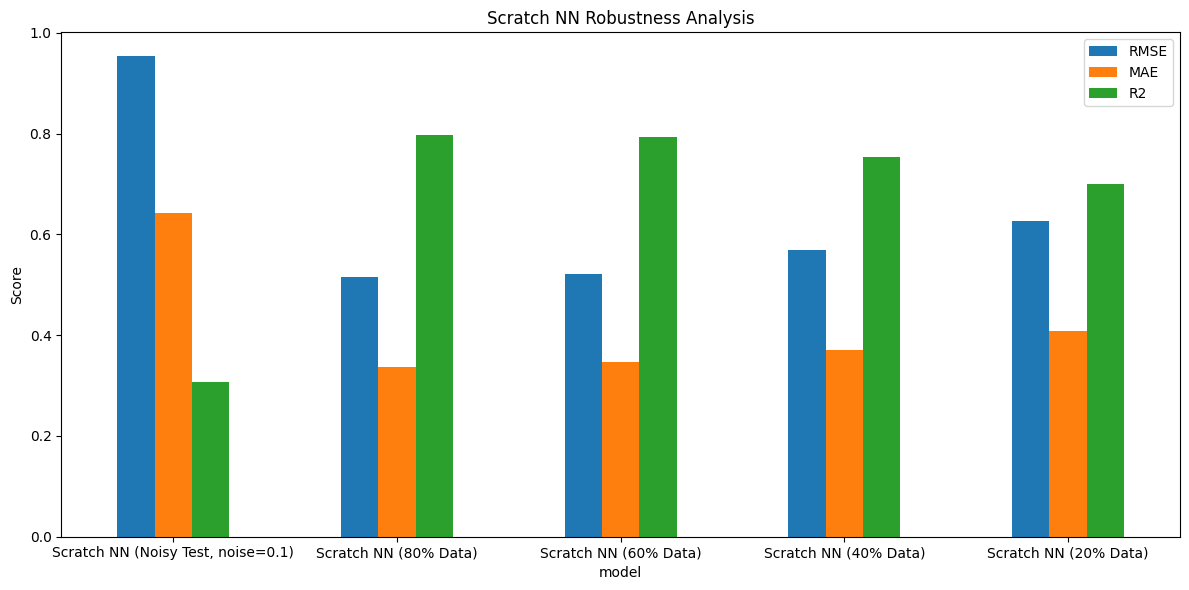

In [ ]:
# Filter results for optimizer comparison
optimizer_models = ["Scratch NN", "Scratch NN (SGD)", "Scratch NN (Momentum)"]
df_optimizers = df_results[df_results["model"].isin(optimizer_models)].set_index("model")[["RMSE", "MAE", "R2"]]

# Bar plot for optimizer comparison
df_optimizers.plot(kind="bar", figsize=(8, 5), rot=0)
plt.title("Scratch NN Optimizer Comparison")
plt.ylabel("Score")
save_fig("figures/scratch_nn_optimizer_comparison.png")

# Filter results for activation function comparison
activation_models = ["Scratch NN", "Scratch NN (Tanh)", "Scratch NN (LeakyReLU)"]
df_activations = df_results[df_results["model"].isin(activation_models)].set_index("model")[["RMSE", "MAE", "R2"]]

# Bar plot for activation function comparison
df_activations.plot(kind="bar", figsize=(8, 5), rot=0)
plt.title("Scratch NN Activation Function Comparison")
plt.ylabel("Score")
save_fig("figures/scratch_nn_activation_comparison.png")

# Filter results for architecture comparison
architecture_models = [m for m in df_results["model"].unique() if "Scratch NN (Arch:" in m]
df_architectures = df_results[df_results["model"].isin(architecture_models)].set_index("model")[["RMSE", "MAE", "R2"]]

# Bar plot for architecture comparison
df_architectures.plot(kind="bar", figsize=(12, 6), rot=0)
plt.title("Scratch NN Architecture Comparison")
plt.ylabel("Score")
save_fig("figures/scratch_nn_architecture_comparison.png")

# Filter results for robustness analysis
robustness_models = [m for m in df_results["model"].unique() if "Noisy Test" in m or "% Data" in m]
df_robustness = df_results[df_results["model"].isin(robustness_models)].set_index("model")[["RMSE", "MAE", "R2"]]

# Bar plot for robustness analysis
df_robustness.plot(kind="bar", figsize=(12, 6), rot=0)
plt.title("Scratch NN Robustness Analysis")
plt.ylabel("Score")
save_fig("figures/scratch_nn_robustness_comparison.png")

**Reasoning**:
Save the final df_results DataFrame to a CSV file and finalize the subtask.



In [ ]:
# Save the final results DataFrame to CSV
df_results.to_csv("results/all_metrics_summary.csv", index=False)

## Summary:

### Data Analysis Key Findings

*   Among the scratch-implemented optimizers, Adam achieved the lowest MSE (0.2586), outperforming SGD (0.2958) and Momentum (1.3113) with the given hyperparameters and epochs.
*   Increasing the depth and width of the scratch neural network architecture generally led to improved performance (lower MSE/RMSE, higher R2) compared to a single hidden layer architecture.
*   Introducing a Gaussian noise level of 0.1 to the test data significantly degraded the performance of the scratch neural network, increasing MSE from approximately \$0.25\$ to \$0.91\$ and decreasing the R2 score from \$0.80\$ to \$0.31\$.
*   Reducing the training data size for the scratch neural network resulted in a gradual decrease in performance, highlighting the importance of sufficient training data for generalization.
*   Comparing the scratch NN with other models, XGBoost showed the best performance with an R2 score of \$0.842242\$, followed by Random Forest (0.805275), and the Scratch NN (0.80) and Keras NN performing comparably well. Linear Regression was the lowest performing baseline (0.575788).

### Insights or Next Steps

*   Further hyperparameter tuning for the Momentum optimizer and the Scratch NN architectures and activation functions could potentially improve their performance.
*   Investigating techniques to improve the robustness of the scratch-implemented neural network to noisy data, such as data augmentation or regularization methods, would be a valuable next step.
